In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [3]:
df = pd.read_parquet("cmm_erdos_bootcamp_2020_timeseries.pq", engine='pyarrow')
df.date_val = pd.to_datetime(df.date_val)

# Moving average smoothing

In [4]:
def ma(vals, k):
    """Performs moving average smoothing. k determines how many points
    on each side of a point to include in the average."""
    res = vals[k : len(vals)-k]
    for j in range(k):
        i = j + 1
        res = res + vals[k-i : len(vals)-k-i]
        res = res + vals[k+i : len(vals)-k+i]
        
    res = res / (2*k + 1)
    
    # concatenate extra stuff on each side of res just to make it
    # have the same shape as vals
    res = np.concatenate([res[:k], res, res[-k:]])
    
    return res

In [5]:
def find_trend(vals, holiday_inds=None, ax=None, label=""):
    vals_copy = vals.copy()
    
    # taming the holidays if their indices are provided
    if holiday_inds is not None:
        for i in holiday_inds:
            vals_copy[i] = vals_copy[i - 7]

    season_washed_away = ma(vals_copy, 3) # 3 because 3+1+3=7 is the period
    trend = ma(season_washed_away, 20) # 20 was chosen arbitrarily

    if ax is not None:
        ax.plot(season_washed_away, lw=1, label=label)
        ax.plot(trend, lw=1, c='r')
        ax.legend()
    
    return season_washed_away, trend

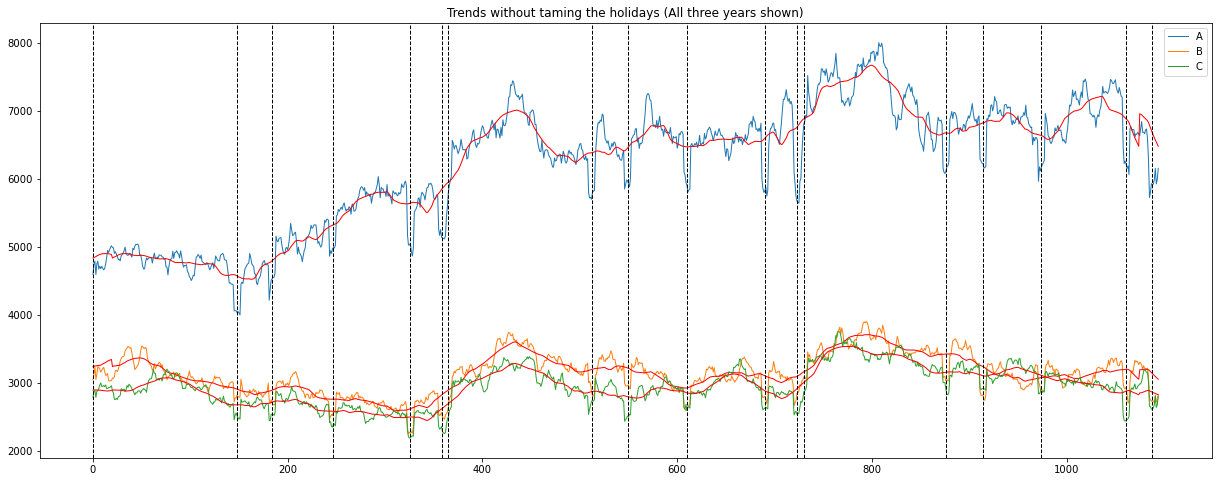

In [6]:
fig, ax = plt.subplots(figsize=(21, 8))
ax.set_title("Trends without taming the holidays (All three years shown)")

find_trend(df.volume_A.values, None, ax, label="A")
find_trend(df.volume_B.values, None, ax, label="B")
find_trend(df.volume_C.values, None, ax, label="C")


# plot vertical lines for the holidays locaions
for ind in df.index[df.is_holiday == 1]:
    ax.axvline(ind, lw=1, ls='--', c='k')

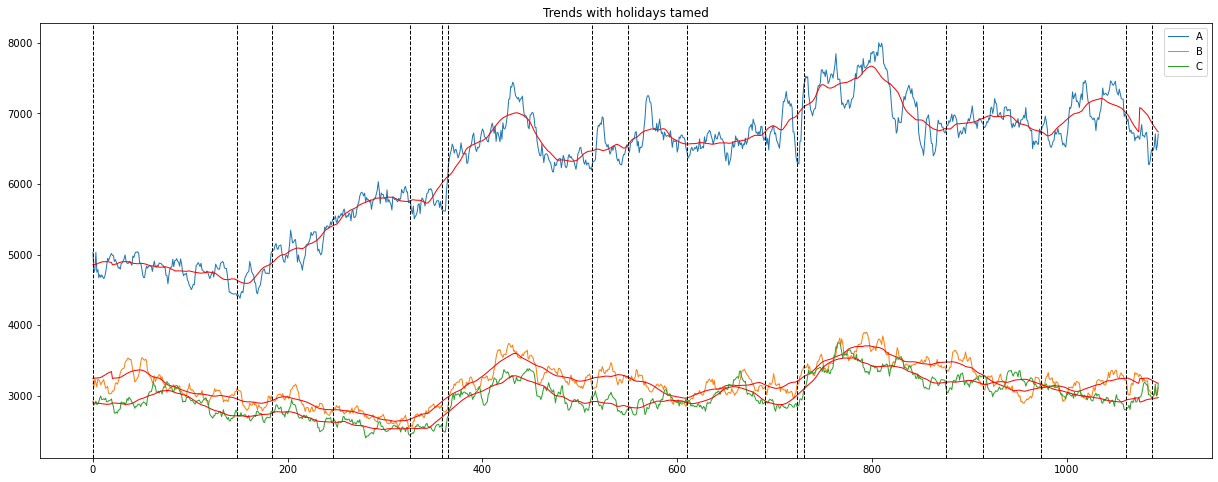

In [7]:
fig, ax = plt.subplots(figsize=(21, 8))
ax.set_title("Trends with holidays tamed")

holiday_inds = df.index[df.is_holiday == 1]

find_trend(df.volume_A.values, holiday_inds, ax, label="A")
find_trend(df.volume_B.values, holiday_inds, ax, label="B")
find_trend(df.volume_C.values, holiday_inds, ax, label="C")


# plot vertical lines for the holidays locaions
for ind in holiday_inds:
    ax.axvline(ind, lw=1, ls='--', c='k')

# Trend Extraction Using STL Decomposition

In [8]:
from statsmodels.tsa.seasonal import STL

In [9]:
vol_a = df.volume_A.values
vol_b = df.volume_B.values
vol_c = df.volume_C.values

#for i in df.index[df.is_holiday == 1]:
#    vol_a[i] = vol_a[i - 7]
#    vol_b[i] = vol_b[i - 7]
#    vol_c[i] = vol_c[i - 7]

stl_a = STL(vol_a, 7).fit()
stl_b = STL(vol_b, 7).fit()
stl_c = STL(vol_c, 7).fit()

trend_a, rest_a = stl_a.trend, (stl_a.resid + stl_a.seasonal)

In [10]:
def normalize(vals):
    return (vals - vals.mean()) / (vals.max() - vals.min())

NameError: name 'trend_b' is not defined

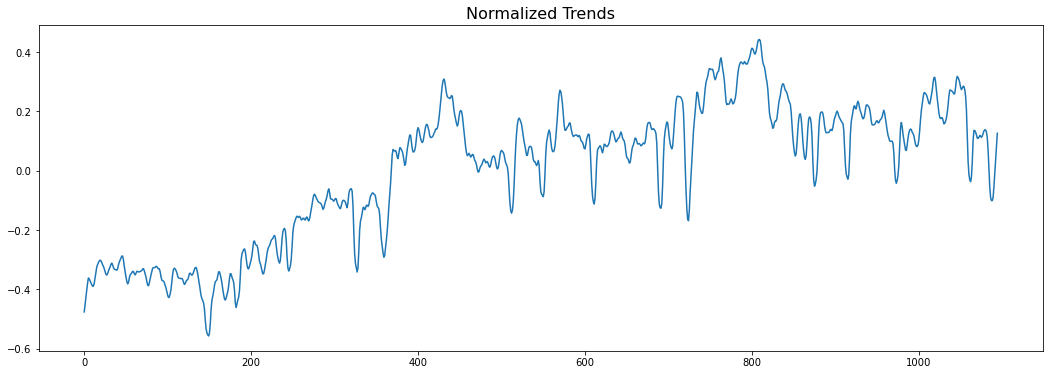

In [11]:
plt.figure(figsize=(18, 6))

plt.title("Normalized Trends", fontsize=16)
plt.plot(normalize(trend_a), label="Trend: A")
plt.plot(normalize(trend_b), label="Trend: B")
plt.plot(normalize(trend_c), label="Trend: C")
plt.legend(fontsize=16)
plt.grid()

plt.show()

# VARMAX on trend

In [12]:
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency
for i in range(100):
    v1 = random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
data_exog = [x + random() for x in range(100)]
# fit model
model = VARMAX(data, exog=data_exog, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
data_exog2 = [[100]]
yhat = model_fit.forecast(exog=data_exog2)
print(yhat)

NameError: name 'data' is not defined

In [14]:
data = np.array([vol_a, vol_b, vol_c]).T
exog = df.is_holiday.values
exog_train, exog_test = exog[365:-365], exog[-365:]
train, test = data[365:-365], data[-365:]

In [15]:
train

array([[3037, 1603, 1342],
       [8646, 3752, 3712],
       [8332, 3770, 4066],
       ...,
       [2968, 1482, 1229],
       [2654, 1453, 1173],
       [8401, 3674, 3411]])

In [16]:
exog_train

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
model = VARMAX(train, order=(1, 0))

In [20]:
model_fit = model.fit(disp=False)
forecast = model_fit.get_forecast(len(test))

UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [19]:
forecast_a = forecast.T[0]
forecast_b = forecast.T[1]
forecast_c = forecast.T[2]

test_a = test.T[0]
test_b = test.T[1]
test_c = test.T[2]

NameError: name 'forecast' is not defined

In [21]:
def mape(test, forecast):
    return np.abs((test - forecast) / test).mean()

In [22]:
mape(test_a, forecast_a)

NameError: name 'test_a' is not defined

/home/mohammed/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/mohammed/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/mohammed/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


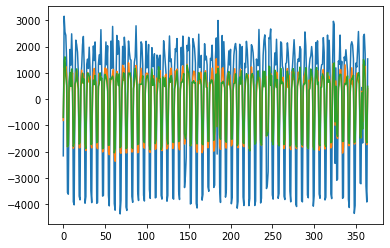

In [23]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL

def sVARMAX(train, test, exog_train, exog_test, order, sorder):
    trainT = train.T
    trendT = []
    restT = []
    for series in trainT:
        series_stl = STL(series, 7).fit()
        trendT.append(series_stl.trend)
        restT.append(series_stl.resid + series_stl.seasonal)
    trendT = np.array(trendT)
    restT = np.array(restT)
    
    varmax_model = VARMAX(trendT.T, exog=None, order=(2, 1))
    varmax_fit = varmax_model.fit(disp=False)
    
    # trend forecast
    trend_forecast = varmax_fit.forecast(len(test), exog=exog_test)
    
    rest_forecast_T = []
    for rest in restT:
        plt.plot(rest)
        
        sarimax_model = SARIMAX(rest, exog_train, order=order, seasonal_order=sorder)
        sarimax_fit = sarimax_model.fit(disp=False, method='powell')
        rest_forecast_T.append(sarimax_fit.forecast(len(test), exog=exog_test))
    
    rest_forecast_T = np.array(rest_forecast_T)
    rest_forecast = rest_forecast_T.T
    
    forecast = trend_forecast + rest_forecast
    return forecast

forecast = sVARMAX(train, test, exog_train, exog_test, (1, 0, 1), (2, 1, 2, 7))

In [30]:
import pandas as pd

In [33]:
fc_df = pd.DataFrame(forecast, columns=['a', 'b', 'c'])
fc_df.to_csv("aaa.csv")

In [24]:
mapes = np.abs((forecast - test) / test).T

In [25]:
mapes

array([[0.27588908, 0.126882  , 0.07251584, ..., 0.08011721, 0.00570668,
        0.00700637],
       [0.45609812, 0.07634503, 0.06542872, ..., 0.04072821, 0.02101719,
        0.01509101],
       [0.07169999, 0.01673729, 0.08337954, ..., 0.06455596, 0.10986071,
        0.08366593]])

0.09815798993922768
0.0785607451706943
0.09372710048331072
0.11737724612642297
0.10420067128573166
0.12800182040448502
0.07880464538932865
0.08350249760079373
0.08847976049140432


NameError: name 'test_a' is not defined

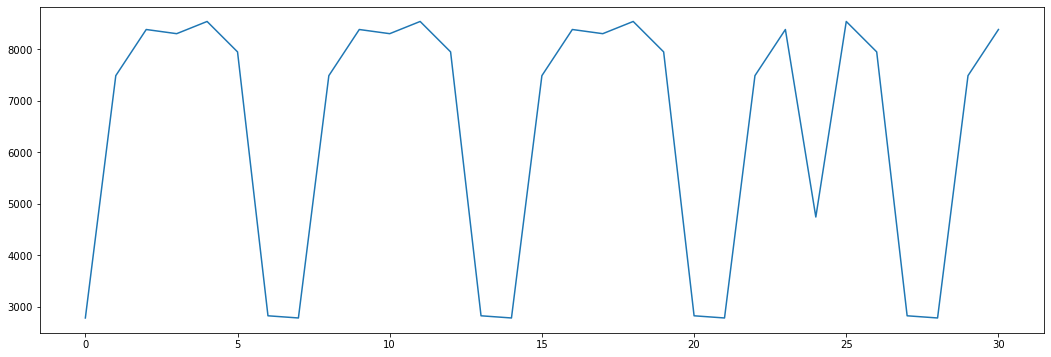

In [26]:
print(mapes[0][:30].mean())
print(mapes[1][:30].mean())
print(mapes[2][:30].mean())

print(mapes[0][:90].mean())
print(mapes[1][:90].mean())
print(mapes[2][:90].mean())

print(mapes[0][:].mean())
print(mapes[1][:].mean())
print(mapes[2][:].mean())

plt.figure(figsize=(18, 6))
plt.plot(forecast.T[0][-31:])
plt.plot(test_a[-31:])

In [ ]:
test

In [ ]:
plt.plot(forecast)

In [ ]:
plt.plot(data)